$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$

$\newcommand{\R}{\bb{R}}$

$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$

$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2 }}$

# Finite Dimensional Koopman Bilinear System

Consider a nonlinear dynamical system that allows an exact finite dimensional Koopman canonical transform such that the control-affine dynamics can be transformed to a bilinear system. Consider the dynamical system 

\begin{equation}
\mb{\dot{x}}=\mb{f}_0(\mb x) + \mb f_1 ( \mb x) u_1 + \mb f_2(\mb x) u_2, 
\end{equation}

where we for this example choose $\mb f_0, \mb f_1$ as follows:

\begin{equation}
\mb f_0(\mb x) = \begin{bmatrix} x_3 \\ x_4 \\ \lambda x_3 \\ \mu x_4 + (2 \lambda - \mu) c x_3^2 \end{bmatrix}, \qquad
\mb f_1(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}, \qquad
\mb f_2(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 0 \\ x_1+1 \end{bmatrix}, 
\end{equation}   

and $\lambda, \mu, c \in \mathbb{R}$ are scalar parameters of the system. Setting $ \mb x = [q_1 \, q_2 \, \dot{q_1} \, \dot{q_2}]^T$, 
these equations of motion can be expressed as robotic dynamics of the form $\mb{D}(\mb{q})\ddot{\mb{q}} + \mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q}) = \mb{B}\mb{u}$, where $\mb D$ is the inertia matrix, $\mb C$ is the matrix of Coriolis terms, $\mb G$ is the matrix of gravitational terms, and $\mb B$ is the static actuation matrix. Rewriting $\mb f_0, \mb f_1, \mb f_2$ in terms of $\mb D, \mb C, \mb G,$ and $\mb B$ yield



\begin{equation}
\mb D(\mb q) = \begin{bmatrix} 1 & 0\\ 0 &  \frac{1}{q_1+1} \end{bmatrix}, 
\qquad \mb C(\mb q, \mb{\dot{q}}) = -\begin{bmatrix} \lambda & 0 \\ \frac{1}{q_1 + 1}(2 \lambda - \mu) c \dot{q}_1 & \frac{1}{q_1 +1} \mu \end{bmatrix}, \qquad 
\mb G(\mb q) = \begin{bmatrix} 0 \\ 0 \end{bmatrix} 
\qquad \mb B = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix},
\end{equation}

In [1]:
import numpy as np
import sys
sys.path.append('../../')

# Define experiment parameters

In [2]:
from core.dynamics import RoboticDynamics, ConfigurationDynamics

class KoopPdOutput(ConfigurationDynamics):
    def __init__(self, dynamics, xd, n, m):
        ConfigurationDynamics.__init__(self, dynamics, 1)
        self.xd = xd
        self.n = n
        self.m = m

    def proportional(self, x, t):
        q = x[:int(n/2)]
        q_d = self.xd[:int(n/2)]

        return  q - q_d

    def derivative(self, x, t):
        q_dot = x[int(n/2):]
        q_dot_d = self.xd[int(n/2):]

        return q_dot - q_dot_d

class FiniteDimKoopSys(RoboticDynamics):
    def __init__(self, lambd, mu, c):
        RoboticDynamics.__init__(self, 2, 2)
        self.params = lambd, mu, c
    
    def D(self, q):
        return np.array([[1, 0],[0, (q[0]+1)**(-1)]])
    
    def C(self, q, q_dot):
        labmd, mu, c = self.params
        return -np.array([[lambd, 0], [(q[0]+1)**(-1)*(2*lambd - mu)*c*q_dot[0], (q[0]+1)**(-1)*mu]])
    
    def G(self, q):
        return np.array([0, 0])
    
    def B(self, q):
        return np.array([[1, 0], [0, 1]])
    
class FiniteDimKoopSysDiscrete(FiniteDimKoopSys):
    def __init__(self, lambd, mu, c, dt):
        FiniteDimKoopSys.__init__(self, lambd, mu, c)
        self.dt = dt

    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        lambd, mu, c = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 1, 0],
                                            [0, 0, 0, 1],
                                            [0, 0, lambd, 0],
                                            [u0[1], 0, 2*(2*lambd-mu)*c*x0[2], mu]])

        B_lin = self.dt*np.array([[0, 0],
                          [0, 0],
                          [1, 0],
                          [0, x0[0]+1]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin

n, m = 4, 2
lambd, mu, c = .3, .2, -.5
finite_dim_koop_sys = FiniteDimKoopSys(lambd, mu, c)

In [3]:
from koopman_core.dynamics import LinearLiftedDynamics

A_lin = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, lambd, 0],
                  [0, 0, 0, mu]])
B_lin = np.array([[0, 0],
                  [0, 0],
                  [1, 0],
                  [0, 1]])
dt = 1e-2
linearized_sys = LinearLiftedDynamics(A_lin, B_lin, np.eye(n), lambda x: x)

# MPC parameters:
umax = np.array([7.5, 7.5])
umin = -umax
xmax = np.array([6., 6., 5., 5.])
xmin = -xmax
Q_mpc = 1*np.diag([1, 1, 1e-1, 1e-1])
QN_mpc = 1e4*np.eye(n)
R_mpc = np.eye(m)
traj_duration = 2
traj_length = int(traj_duration/dt)

# Design trajectory:
x0 = np.array([0., 0., 0., 0.])
set_pt = np.array([5., 3., 0., 0.])
term_constraint = True

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0, set_pt, int(traj_length)+1)
u_init = np.ones((m,traj_length)).T

# Construct Koopman bilinear form of the system

As a result of the careful construction of this system, there exists a Koopman canonical transform, $\mb z = T(\mb x)$ that exactly transforms the control-affine dynamics into a bilinear system. Consider the transformation:

\begin{equation}
    T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 
    \phi_1(\mb q, \mb{\dot{q}})\\
    \phi_2(\mb q, \mb{\dot{q}})\\
    \phi_3(\mb q, \mb{\dot{q}})\\
    \phi_4(\mb q, \mb{\dot{q}})\\
    \phi_5(\mb q, \mb{\dot{q}})\\
    \phi_6(\mb q, \mb{\dot{q}})\\
    \end{bmatrix}
    = \begin{bmatrix} 
    1\\
    q_1 - \frac{1}{\lambda}\dot{q}_1\\
    q_2 - \frac{1}{\mu} \dot{q}_2 + \frac{(2 \lambda - \mu)c}{2\lambda \mu} \dot{q}_1^2\\
    \dot{q}_1\\
    \dot{q}_2 - c \dot{q}_1^2\\
    \dot{q}_1^2\\
    \end{bmatrix},
\end{equation}

where $\phi_1, \phi_2, \phi_3, \phi_4, \phi_5, \phi_6$ are eigenfunctions of the Koopman operator associated with the drift 
vector field $\mb f_0$. The matrix with the eigenvalue associated with the i-th eigenfunction on the i-th diagonal 
element is $F=\text{diag}(0, 0, \lambda, \mu, 2 \lambda, 0)$. Then, to reformulate the dynamics we have: 

\begin{equation} 
L_{\mb f_1} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0\\ -\frac{1}{\lambda}\\ \frac{(2\lambda - \mu)c}{\lambda \mu}\dot{q}_1\\ 1 \\ -2c\dot{q}_1 \\ 2\dot{q_1} \end{bmatrix}, \qquad 
L_{\mb f_2} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0 \\ 0\\ -\frac{1}{\mu}(q_1 + 1)\\0 \\ q_1 + 1 \\ 0 \end{bmatrix} 
\end{equation}

and the dynamics can be equivalently transformed to a bilinear form $\mb{\dot{z}} = F \mb z + G_1\mb z u_1 + G_2\mb z u_2$ with 

\begin{equation}
F = \begin{bmatrix} 
0 &0 & 0 & 0 & 0 & 0\\  
0 & 0 & 0 & 0 & 0 & 0\\
0 &0 & 0 & 0 & 0 & 0\\
0 &0 & 0 & \lambda & 0 & 0\\
0 &0 & 0 & 0 & \mu & 0 \\
0 &0 & 0 & 0 & 0 & 2 \lambda\\
\end{bmatrix}, \qquad 
G_1 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
-\frac{1}{\lambda}& 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \frac{(2\lambda - \mu)c}{\lambda \mu} & 0 & 0\\
1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & -2c & 0 & 0\\
0 & 0 & 0 & 2 & 0 & 0\\  
\end{bmatrix}
, \qquad 
G_2 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 &  0 & 0 & 0 & 0\\
 -\frac{1}{\mu} & -\frac{1}{\mu} & 0 &  -\frac{1}{\lambda \mu} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & \frac{1}{\lambda} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}
\end{equation}

In [4]:
from koopman_core.dynamics import BilinearLiftedDynamics

F = np.array([[0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, lambd, 0, 0],
              [0, 0, 0, 0, mu, 0],
              [0, 0, 0, 0, 0, 2*lambd]])
G_1 = np.array([[0, 0, 0, 0, 0, 0],
                [-1/lambd, 0, 0, 0, 0, 0],
                [0, 0, 0, (2*lambd - mu)*c/(lambd*mu), 0, 0],
                [1, 0, 0, 0, 0, 0], 
                [0, 0, 0, -2*c, 0, 0], 
                [0, 0, 0, 2, 0, 0]])
G_2 = np.array([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [-1/mu, -1/mu, 0, -1/(lambd*mu), 0, 0],
                [0, 0, 0, 0, 0, 0], 
                [1, 1, 0, 1/lambd, 0, 0], 
                [0, 0, 0, 0, 0, 0]])
G = [G_1, G_2]
phi_fun = lambda x: np.array([1,
                            x[0,0] - 1/lambd*x[0,2],
                            x[0,1] - 1/mu*x[0,3] + (2*lambd - mu)*c/(2*lambd*mu)*x[0,2]**2,
                            x[0,2],
                            x[0,3] - c*x[0,2]**2,
                            x[0,2]**2])
phi_fun_grad = lambda x: np.array([[0., 0., 0., 0.]
                                   [1., 0., -1/lambd, 0.],
                                   [0., 1., (2*lambd-mu)*c/(lambd*mu)*x[0,2], -1/mu],
                                   [0., 0., 1., 0.],
                                   [0., 0., -2*c*x[0,2], 1.],
                                   [0., 0., 2*x[0,2], 0.]])

C_q = np.array([[0, 1, 0, 1/lambd, 0, 0],
                [0, 0, 1, 0, 1/mu, c/mu - ((2*lambd - mu)*c)/(2*lambd*mu)]])
C_qdot = np.array([[0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 1, c]])
C = np.concatenate((C_q, C_qdot), axis=0)
n_koop = 6

koop_bilinear_sys = BilinearLiftedDynamics(n_koop, m, F, G, C, phi_fun)

#### Verify that the Koopman Bilinear Form model and control-affine model are equivalent

To verify that the models are in fact equivalent we sample a random control sequence and simulate both models forward with the same control sequence. As can be seen below, the resulting trajectories are equivalent.

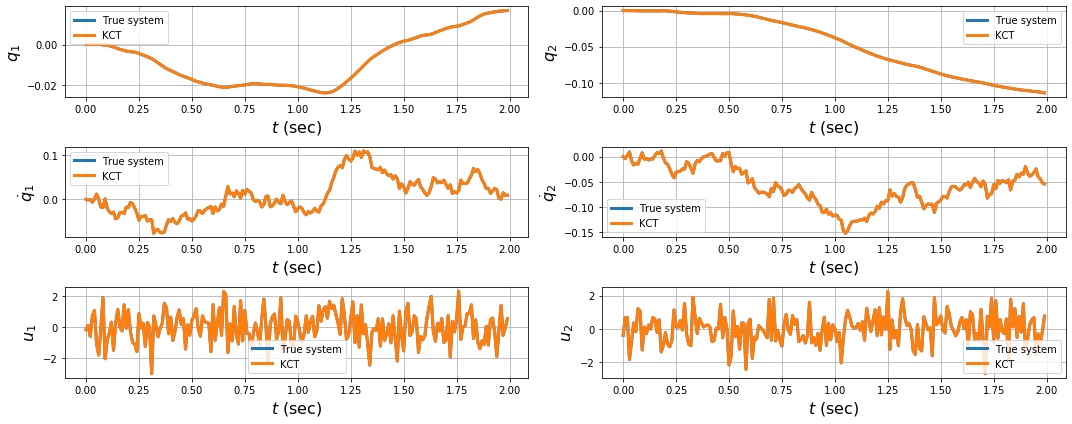

In [5]:
from matplotlib.pyplot import subplots, tight_layout, show
from koopman_core.controllers.openloop_controller import OpenLoopController

ol_controller = OpenLoopController(finite_dim_koop_sys, np.random.normal(size=(2,200)).T, np.arange(0,200)*dt)
z0 = phi_fun(x0.reshape((1,-1)))
xs, us = finite_dim_koop_sys.simulate(x0, ol_controller, np.arange(0,201)*dt)
zs_koop, us_koop = koop_bilinear_sys.simulate(z0, ol_controller, np.arange(0,201)*dt)
xs_koop = np.dot(C, zs_koop.T)

_, axs = subplots(3, 2, figsize=(15, 6))
ylabels = ['$q_1$', '$q_2$', '$\\dot{q}_1$', '$\\dot{q}_2$', '$u_1$', '$u_2$']

for ax, data_fb, data_koop, ylabel in zip(axs.flatten(), np.vstack((xs[:-1,:].T, us.T)), np.vstack((xs_koop[:,:-1], us_koop.T)), ylabels):
    ax.plot(np.arange(0,200)*dt, data_fb, linewidth=3, label='True system')
    ax.plot(np.arange(0,200)*dt, data_koop, linewidth=3, label='KCT')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()
    ax.set_xlabel('$t$ (sec)', fontsize=16)
    ax.legend()
    
tight_layout()
show()

# Collect data for learning 

In [6]:
import scipy as sc

q_dc, r_dc = 5e2, 1                                                 # State and actuation penalty values, data collection
Q_dc = q_dc * np.identity(n)                                        # State penalty matrix, data collection
R_dc = r_dc*np.identity(m)                                          # Actuation penalty matrix, data collection
P_dc = sc.linalg.solve_continuous_are(A_lin, B_lin, Q_dc, R_dc)     # Algebraic Ricatti equation solution, data collection
K_dc = np.linalg.inv(R_dc)@B_lin.T@P_dc                             # LQR feedback gain matrix, data collection
K_dc_p = K_dc[:,:int(n/2)]                                          # Proportional control gains, data collection
K_dc_d = K_dc[:,int(n/2):]                                          # Derivative control gains, data collection

# Data collection parameters:
dt = 1.0e-2                                                         # Time step length
traj_length_dc = 2.                                                 # Trajectory length, data collection
n_pred_dc = int(traj_length_dc/dt)                                  # Number of time steps, data collection
t_eval = dt * np.arange(n_pred_dc + 1)                              # Simulation time points
n_traj_dc = 100                                                      # Number of trajectories to execute, data collection
noise_var = 5.                                                      # Exploration noise to perturb controller, data collection

xmax = np.array([1., 1., 1., 1.])                                   # State constraints, trajectory generation
xmin = -xmax
umax = np.array([10., 10.])                                         # Actuation constraint, trajectory generation
umin = -umax
x0_max = xmax/2                                                     # Initial value limits
sub_sample_rate = 1                                                 # Rate to subsample data for training
model_fname = 'examples/'                                           # Path to save learned models
n_cols = 10                                                         # Number of columns in training data plot

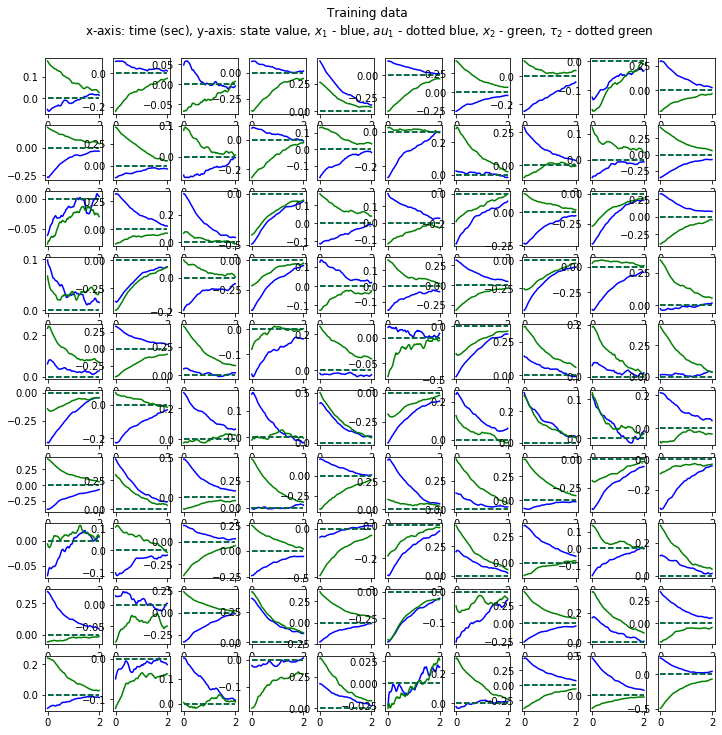

In [7]:
import matplotlib.pyplot as plt
import random as rand
from core.controllers import PDController
from koopman_core.controllers import PerturbedController, OpenLoopController
xs = np.empty((n_traj_dc, n_pred_dc + 1, n))
us = np.empty((n_traj_dc, n_pred_dc, m))

plt.figure(figsize=(12, 12 * n_traj_dc / (n_cols ** 2)))
for ii in range(n_traj_dc):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.zeros(n)

    output = KoopPdOutput(finite_dim_koop_sys, set_pt_dc, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(finite_dim_koop_sys, pd_controller, noise_var)
    #perturbed_pd_controller = OpenLoopController(finite_dim_koop_sys, np.zeros((t_eval.shape[0], m)), t_eval)
    xs[ii, :, :], us[ii, :, :] = finite_dim_koop_sys.simulate(x0, perturbed_pd_controller, t_eval)

    plt.subplot(int(np.ceil(n_traj_dc / n_cols)), n_cols, ii + 1)
    plt.plot(t_eval, xs[ii, :, 0], 'b', label='$x_1$')
    plt.plot(t_eval, xs[ii, :, 1], 'g', label='$x_2$')
    plt.plot(t_eval, set_pt_dc[0]*np.ones_like(xs[ii,:,0]), '--b', label='$\\tau_1$')
    plt.plot(t_eval, set_pt_dc[1]*np.ones_like(xs[ii,:,0]), '--g', label='$\\tau_2$')

plt.suptitle(
    'Training data \nx-axis: time (sec), y-axis: state value, $x_1$ - blue, $\tau_1$ - dotted blue, $x_2$ - green, $\\tau_2$ - dotted green',
    y=0.94)
plt.show()

# Learn Koopman-based models of the dynamics

### Learn bilinear EDMD model

In [8]:
#Bilinear EDMD parameters:                                           
alpha_bedmd = 2.4e-5  # Regularization strength (LASSO) bEDMD
tune_mdl_bedmd = False

In [9]:
from sklearn import preprocessing, linear_model
from koopman_core.learning import BilinearEdmd
from koopman_core.dynamics import BilinearLiftedDynamics

bedmd_features = preprocessing.PolynomialFeatures(2)
bedmd_features.fit(np.zeros((1,n)))
n_lift_bedmd = bedmd_features.transform((np.zeros((1,n)))).shape[1]

C_bedmd = np.zeros((n,n_lift_bedmd))
C_bedmd[:,1:n+1] = np.eye(n)

basis_bedmd = lambda x: bedmd_features.transform(x)
optimizer_bedmd = linear_model.MultiTaskLasso(alpha=alpha_bedmd, fit_intercept=False, selection='random')
cv_bedmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_bedmd = preprocessing.StandardScaler(with_mean=False)

model_bedmd = BilinearEdmd(n, m, basis_bedmd, n_lift_bedmd, n_traj_dc, optimizer_bedmd, cv=cv_bedmd, standardizer=standardizer_bedmd, C=C_bedmd, continuous_mdl=False, dt=dt)
X_bedmd, y_bedmd = model_bedmd.process(xs, us, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_bedmd.fit(X_bedmd, y_bedmd, cv=tune_mdl_bedmd, override_kinematics=True)
sys_bedmd = BilinearLiftedDynamics(model_bedmd.n_lift, m, model_bedmd.A, model_bedmd.B, model_bedmd.C, model_bedmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_bedmd:
    print('$\\alpha$ bilinear EDMD: ', model_bedmd.cv.alpha_)

### Learn Koopman DNN model

In [10]:
from koopman_core.learning import KoopDnn

net_params = {}
net_params['state_dim'] = n
net_params['ctrl_dim'] = m
net_params['encoder_hidden_dim'] = [100, 100]
net_params['encoder_output_dim'] = 10
net_params['optimizer'] = 'adam'
net_params['lr'] = 0.0001
net_params['epochs'] = 30
net_params['batch_size'] = 64
net_params['lin_loss_penalty'] = 5e-1/net_params['encoder_output_dim']
net_params['weight_decay'] = 1e-6
net_params['l1_reg'] = 0
net_params['n_multistep'] = 1
net_params['first_obs_const'] = True
net_params['override_kinematics'] = True
net_params['dt'] = dt

In [11]:
n_tot = net_params['state_dim'] + net_params['encoder_output_dim'] + int(net_params['first_obs_const'])
model_koop_dnn = KoopDnn(n_traj_dc, net_params)
X_koop_dnn, y_koop_dnn = model_koop_dnn.process(xs, us, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_koop_dnn.fit(X_koop_dnn, y_koop_dnn)
sys_koop_dnn = BilinearLiftedDynamics(n_tot, m, model_koop_dnn.A, model_koop_dnn.B, model_koop_dnn.C, model_koop_dnn.basis_encode, continuous_mdl=False, dt=dt)

[1,   100] loss: 0.03031022
[1,   200] loss: 0.01998695
[1,   300] loss: 0.01572668
[2,   100] loss: 0.01459364
[2,   200] loss: 0.01435508
[2,   300] loss: 0.01405945
[3,   100] loss: 0.01390875
[3,   200] loss: 0.01382066
[3,   300] loss: 0.01369954
[4,   100] loss: 0.01368931
[4,   200] loss: 0.01359389
[4,   300] loss: 0.01358714
[5,   100] loss: 0.01361264
[5,   200] loss: 0.01347574
[5,   300] loss: 0.01356323
[6,   100] loss: 0.01354154
[6,   200] loss: 0.01350281
[6,   300] loss: 0.01349286
[7,   100] loss: 0.01354267
[7,   200] loss: 0.01348943
[7,   300] loss: 0.01343710
[8,   100] loss: 0.01354731
[8,   200] loss: 0.01347219
[8,   300] loss: 0.01341571
[9,   100] loss: 0.01348985
[9,   200] loss: 0.01346791
[9,   300] loss: 0.01344015
[10,   100] loss: 0.01335181
[10,   200] loss: 0.01352593
[10,   300] loss: 0.01346653
[11,   100] loss: 0.01348018
[11,   200] loss: 0.01344137
[11,   300] loss: 0.01344115
[12,   100] loss: 0.01346330
[12,   200] loss: 0.01340791
[12,   300] 

# Evaluate open-loop prediction performance

In [12]:
# Prediction performance evaluation parameters:
folder_plots = 'figures/'                                          # Path to save plots
n_traj_ol = 50                                                     # Number of trajectories to execute, open loop

In [13]:
from tabulate import tabulate

xs_ol = np.empty((n_traj_ol, t_eval.shape[0], n))
xs_bedmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_koop_dnn_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
us_test = np.empty((n_traj_ol, t_eval.shape[0]-1, m))

for ii in range(n_traj_ol):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.zeros(n)
    
    output = KoopPdOutput(finite_dim_koop_sys, set_pt_dc, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(finite_dim_koop_sys, pd_controller, noise_var)
    xs_ol[ii, :, :], us_test[ii, :, :] = finite_dim_koop_sys.simulate(x0, perturbed_pd_controller, t_eval)
    ol_controller_nom = OpenLoopController(sys_bedmd, us_test[ii,:,:], t_eval[:-1])

    z_0_bedmd = sys_bedmd.basis(np.atleast_2d(x0)).squeeze()
    zs_bedmd_tmp, _ = sys_bedmd.simulate(z_0_bedmd, ol_controller_nom, t_eval[:-1])
    xs_bedmd_ol[ii,:,:] = np.dot(model_bedmd.C, zs_bedmd_tmp.T).T
    
    z_0_koop_dnn = sys_koop_dnn.basis(np.atleast_2d(x0)).squeeze()
    zs_koop_dnn_tmp, _ = sys_koop_dnn.simulate(z_0_koop_dnn, ol_controller_nom, t_eval[:-1])
    xs_koop_dnn_ol[ii,:,:] = np.dot(model_koop_dnn.C, zs_koop_dnn_tmp.T).T

data = [xs_bedmd_ol, xs_koop_dnn_ol]
mdl_names = ['bEDMD', 'Koop DNN']
error, mse, std = [], [], []

for ii, d in enumerate(data):
    err_tmp = xs_ol[:,:-1,:]-d
    error.append(err_tmp)
    mse.append(np.mean(np.square(error[ii])))
    std.append(np.std(error[ii]))
    
print('\nOpen loop performance statistics:')

table_data = []
for name, mse_mdl, std_mdl in zip(mdl_names, mse, std):
    table_data.append([name, "{:.5f}".format(mse_mdl), "{:.5f}".format(std_mdl)])

print(tabulate(table_data, 
               headers=['Mean squared error', 'Standard deviation']))


Open loop performance statistics:
            Mean squared error    Standard deviation
--------  --------------------  --------------------
bEDMD             0                      0.00222
Koop DNN          2.42096e+158           1.55589e+79


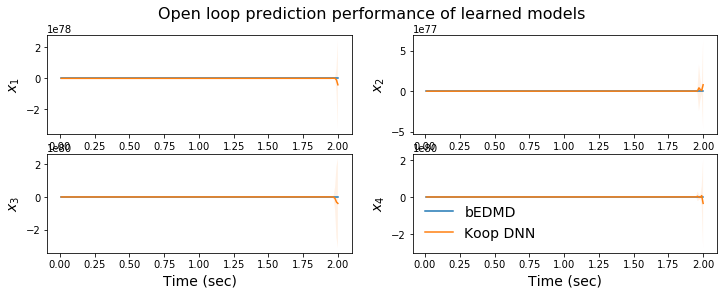

In [14]:
import matplotlib.pyplot as plt
import matplotlib

figwidth = 12
lw = 2
fs = 14
y_lim_gain = 1.2
row = 2
col = n/row

#Plot open loop results:
plt.figure(figsize=(figwidth,4))
axs = [plt.subplot(row,col,jj+1) for jj in range(n)]

for ii, err in enumerate(error):
    err_mean = np.mean(err, axis=0)
    err_std = np.std(err, axis=0)
    
    for jj in range(n):
        axs[jj].plot(t_eval[1:], err_mean[:,jj], label=mdl_names[ii])
        axs[jj].fill_between(t_eval[1:], err_mean[:,jj]-err_std[:,jj], err_mean[:,jj]+err_std[:,jj], alpha=0.1)

for jj in range(n):
    axs[jj].set_xlabel('Time (sec)', fontsize=fs)
    axs[jj].set_ylabel('$x_'+ str(jj+1) + '$', fontsize=fs)

plt.legend(frameon=False, fontsize=fs)
stitle=plt.suptitle('Open loop prediction performance of learned models', fontsize=fs+2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.savefig(folder_plots + 'koop_sys_prediction.pdf', format='pdf', dpi=2400, bbox_extra_artists=(stitle,), bbox_inches="tight")
plt.show()

# Design model predictive controllers

#### Linear model predictive controller

In [15]:
from koopman_core.controllers import MPCController

controller_lmpc = MPCController(linearized_sys, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint, add_slack=True)

#### Bilinear model predictive controller

In [16]:
from koopman_core.controllers import NonlinearMPCController, BilinearMPCController

# Define rough discrete-time model:
A_d = np.eye(n_koop) + koop_bilinear_sys.A*dt
B_d = [b*dt for b in koop_bilinear_sys.B]
kbf_d = BilinearLiftedDynamics(n_koop, m, A_d, B_d, C, koop_bilinear_sys.basis, continuous_mdl=False, dt=dt)

# Define kbf controller:
controller_knmpc = BilinearMPCController(kbf_d, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint)
z0 = phi_fun(x0.reshape((1,-1)))
z_init = np.array([phi_fun(x.reshape((1,-1))) for x in x_init])
controller_knmpc.construct_controller(z_init, u_init)

#### Nonlinear model predictive controller

In [17]:
finite_dim_koop_sys_d = FiniteDimKoopSysDiscrete(lambd, mu, c, dt)
controller_nmpc = NonlinearMPCController(finite_dim_koop_sys_d, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint)
controller_nmpc.construct_controller(x_init, u_init)

# Evaluate performance of controllers for trajectory generation

#### Design trajectories with the constructed MPCs

In [18]:
max_iter = 50

controller_lmpc.eval(x0, 0)
xr_lmpc = controller_lmpc.parse_result()
ur_lmpc = controller_lmpc.get_control_prediction()

controller_knmpc.solve_to_convergence(z0, 0., z_init, u_init, max_iter=max_iter)
xr_knmpc = koop_bilinear_sys.C@controller_knmpc.get_state_prediction().T
ur_knmpc = controller_knmpc.get_control_prediction().T

controller_nmpc.solve_to_convergence(x0, 0., x_init, u_init, max_iter=max_iter)
xr_nmpc = controller_nmpc.get_state_prediction().T
ur_nmpc = controller_nmpc.get_control_prediction().T

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

#### Simulate designed trajectories open-loop

In [ ]:
from koopman_core.controllers import OpenLoopController
t_eval = np.arange(0,traj_length+1)*dt
ol_controller_lmpc = OpenLoopController(finite_dim_koop_sys, ur_lmpc.T, t_eval[:-1])
xs_lmpc, us_lmpc = finite_dim_koop_sys.simulate(x0, ol_controller_lmpc, t_eval)
xs_lmpc, us_lmpc = xs_lmpc.T, us_lmpc.T

ol_controller_knmpc = OpenLoopController(finite_dim_koop_sys, ur_knmpc.T, t_eval[:-1])
xs_knmpc, us_knmpc = finite_dim_koop_sys.simulate(x0, ol_controller_knmpc, t_eval)
xs_knmpc, us_knmpc = xs_knmpc.T, us_knmpc.T

ol_controller_nmpc = OpenLoopController(finite_dim_koop_sys, ur_nmpc.T, t_eval[:-1])
xs_nmpc, us_nmpc = finite_dim_koop_sys.simulate(x0, ol_controller_nmpc, t_eval)
xs_nmpc, us_nmpc = xs_nmpc.T, us_nmpc.T

#### Plot/analyze the results

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tabulate import tabulate

plot_inds = [0, 2, 1, 3, 0, 1]
subplot_inds = [1, 2, 4, 5, 3, 6]
labels = ['$x_1$ (m)', '$x_2$ (m)', '$\\dot{x}_1$ (m/s)','$\\dot{x}_2$ (m/s)','$F_1$ (N)','$F_2$ (N)']
colors = ['tab:blue', 'tab:orange', 'tab:brown']

plt.figure(figsize=(15,8))
plt.suptitle('Trajectory designed with model predictive controllers\nsolid lines - designed trajectory | dashed lines - open loop simulated trajectory | black dotted lines - state/actuation bounds')
for ii in range(6):
    ind = plot_inds[ii]
    if ii < 4:
        plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval, xr_lmpc[ind,:], colors[0], label='Linear MPC')
        plt.plot(t_eval, xr_knmpc[ind, :], colors[1], label='Bilinear MPC')
        plt.plot(t_eval, xr_nmpc[ind,:], colors[2], label='Nonlinear MPC')

        plt.plot(t_eval, xs_lmpc[ind,:], '--', color=colors[0])
        plt.plot(t_eval, xs_knmpc[ind, :], '--', color=colors[1])
        plt.plot(t_eval, xs_nmpc[ind,:], '--', color=colors[2])

        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.scatter(t_eval[0], x0[ind], color='g')
        plt.scatter(t_eval[-1], set_pt[ind], color='r')
        plt.ylabel(labels[ind])
        plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
    else:
        ax = plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval[:-1],ur_lmpc[ind,:], color=colors[0], label='Linear MPC')
        plt.plot(t_eval[:-1], ur_knmpc[ind, :], color=colors[1], label='Bilinear MPC')
        plt.plot(t_eval[:-1],ur_nmpc[ind,:], color=colors[2], label='Nonlinear MPC')
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii]==3:
            plt.legend(loc='upper right', bbox_to_anchor=(0.975, 0.95), frameon=False)
    if subplot_inds[ii] == 4 or subplot_inds[ii] == 5 or subplot_inds[ii] == 6:
        plt.xlabel('Time (sec)')
            
plt.show()

cost_ref_lmpc = (xr_lmpc[:,-1]-set_pt).T@QN_mpc@(xr_lmpc[:,-1]-set_pt) + np.sum(np.diag(ur_lmpc.T@R_mpc@ur_lmpc))
cost_ref_knmpc = (xr_knmpc[:,-1]-set_pt).T@QN_mpc@(xr_knmpc[:,-1]-set_pt) + np.sum(np.diag(ur_knmpc.T@R_mpc@ur_knmpc))
cost_ref_nmpc = (xr_nmpc[:,-1]-set_pt).T@QN_mpc@(xr_nmpc[:,-1]-set_pt) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

cost_ol_lmpc = (xs_lmpc[:,-1]-set_pt).T@QN_mpc@(xs_lmpc[:,-1]-set_pt) + np.sum(np.diag(ur_lmpc.T@R_mpc@ur_lmpc))
cost_ol_knmpc = (xs_knmpc[:,-1]-set_pt).T@QN_mpc@(xs_knmpc[:,-1]-set_pt) + np.sum(np.diag(ur_knmpc.T@R_mpc@ur_knmpc))
cost_ol_nmpc = (xs_nmpc[:,-1]-set_pt).T@QN_mpc@(xs_nmpc[:,-1]-set_pt) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

print('Quadratic cost (normalized by NMPC cost) of designed and realized trajectories designed with each MPC:\n')
print(tabulate([['Linear MPC', cost_ref_lmpc/cost_ref_nmpc, cost_ol_lmpc/cost_ol_nmpc], 
                ['Koopman bilinear MPC', cost_ref_knmpc/cost_ref_nmpc, cost_ol_knmpc/cost_ol_nmpc],
                ['Nonlinear MPC', 1, 1]], 
               headers=['Designed trajectory', 'Realized trajectory']))

#### Study evolution of the solution after each iteration of the SQP-algorithm

In [ ]:
n_iter = min(len(controller_nmpc.x_iter),len(controller_knmpc.x_iter))

# Calculate cost after each iteration:
iter_cost_nmpc, iter_cost_knmpc = [], []

ol_controller_init = OpenLoopController(finite_dim_koop_sys, u_init, t_eval[:-1])
xs_init, _ = finite_dim_koop_sys.simulate(x0, ol_controller_init, t_eval)
xs_init, us_init = xs_init.T, u_init.T
init_cost = (xs_init[:,-1]-set_pt).T@QN_mpc@(xs_init[:,-1]-set_pt) + np.sum(np.diag(us_init.T@R_mpc@us_init))
iter_cost_nmpc = [init_cost]
iter_cost_knmpc = [init_cost]

for ii in range(n_iter):
    ur_knmpc_iter = controller_knmpc.u_iter[ii].T
    ol_controller_knmpc_iter = OpenLoopController(finite_dim_koop_sys, ur_knmpc_iter, t_eval[:-1])
    xs_knmpc_iter, _ = finite_dim_koop_sys.simulate(x0, ol_controller_knmpc_iter, t_eval)
    xs_knmpc_iter, us_knmpc_iter = xs_knmpc_iter.T, ur_knmpc_iter.T
    iter_cost_knmpc.append((xs_knmpc_iter[:,-1]-set_pt).T@QN_mpc@(xs_knmpc_iter[:,-1]-set_pt) + np.sum(np.diag(us_knmpc_iter.T@R_mpc@us_knmpc_iter)))
    
    ur_nmpc_iter = controller_nmpc.u_iter[ii].T
    ol_controller_nmpc_iter = OpenLoopController(finite_dim_koop_sys, ur_nmpc_iter, t_eval[:-1])
    xs_nmpc_iter, _ = finite_dim_koop_sys.simulate(x0, ol_controller_nmpc_iter, t_eval)
    xs_nmpc_iter, us_nmpc_iter = xs_nmpc_iter.T, ur_nmpc_iter.T
    iter_cost_nmpc.append((xs_nmpc_iter[:,-1]-set_pt).T@QN_mpc@(xs_nmpc_iter[:,-1]-set_pt) + np.sum(np.diag(us_nmpc_iter.T@R_mpc@us_nmpc_iter)))

plt.figure(figsize=(15,8))
plt.suptitle('Control solution after each iteration of the SQP-algorithm for NMPC and K-NMPC')
ax1 = plt.subplot(2,3,1)
ax1.plot(t_eval[:-1],u_init[:, 0])
ax2 = plt.subplot(2,3,2)
ax2.plot(t_eval[:-1],u_init[:, 1], label='Iteration 0')
ax3 = plt.subplot(2,3,4)
ax3.plot(t_eval[:-1],u_init[:, 0])
ax4 = plt.subplot(2,3,5)
ax4.plot(t_eval[:-1],u_init[:, 0])

for it in range(n_iter):
    ax1.plot(t_eval[:-1],controller_nmpc.u_iter[it][0,:])
    ax2.plot(t_eval[:-1],controller_nmpc.u_iter[it][1,:], label='Iteration '+str(it+1))
    ax3.plot(t_eval[:-1],controller_knmpc.u_iter[it][0,:])
    ax4.plot(t_eval[:-1],controller_knmpc.u_iter[it][1,:])
    
ax5 = plt.subplot(1,3,3)
ax5.plot(np.arange(1,n_iter), iter_cost_nmpc[1:n_iter]/iter_cost_nmpc[-1], 'tab:cyan', label='NMPC')
ax5.plot(np.arange(1,n_iter), iter_cost_knmpc[1:n_iter]/iter_cost_nmpc[-1], 'k', label='K-NMPC')

ax1.set_title('Control action sequence at each iteration\n$u_1$')
ax1.set_ylabel('NMPC\nControl value')
ax2.set_title('$u_2$')
ax2.legend(ncol=2, loc='upper right', frameon=False)
ax3.set_ylabel('K-NMPC\nControl value')
ax3.set_xlabel('Time (sec)')
ax4.set_xlabel('Time (sec)')
ax5.set_title('Realized cost after each iteration\n')
ax5.set_xlabel('Iteration')
ax5.set_ylabel('Cost (normalized)')
ax5.legend(loc='upper right', frameon=False)

plt.show()

print('Solution statistics\n')
print(tabulate([['Nonlinear MPC', len(controller_nmpc.x_iter), np.mean(controller_nmpc.comp_time), np.std(controller_nmpc.comp_time), sum(controller_nmpc.comp_time)],
                ['Koopman bilinear MPC', len(controller_knmpc.x_iter), np.mean(controller_knmpc.comp_time), np.std(controller_knmpc.comp_time), sum(controller_knmpc.comp_time)]], 
               headers=['Number of SQP\niterations','Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)', 'Total comp.\ntime (secs)']))

# Evaluate performance of controllers for closed-loop control

#### Design finite horizon controllers

In [ ]:
Q_mpc_cl = 1e2*np.diag([1, 1, 2e-1, 2e-1])
QN_mpc_cl= Q_mpc_cl
R_mpc_cl = np.eye(m)
traj_duration = 0.5
N_cl = int(traj_duration/dt)

controller_lmpc_cl = MPCController(linearized_sys, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, terminal_constraint=False, add_slack=True)
controller_knmpc_cl = BilinearMPCController(kbf_d, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, terminal_constraint=False, add_slack=True)
controller_knmpc_cl.construct_controller(controller_knmpc.cur_z[:N_cl+1,:], controller_knmpc.cur_u[:N_cl,:])
controller_nmpc_cl = NonlinearMPCController(finite_dim_koop_sys_d, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, terminal_constraint=False)
controller_nmpc_cl.construct_controller(controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:])

In [ ]:
controller_knmpc_cl.solve_to_convergence(z0, 0., controller_knmpc.cur_z[:N_cl+1,:], controller_knmpc.cur_u[:N_cl,:], max_iter=max_iter)
controller_nmpc_cl.solve_to_convergence(x0, 0., controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:], max_iter=max_iter)

#### Simulate designed trajectories closed-loop

In [ ]:
xs_lmpc_cl, us_lmpc_cl = finite_dim_koop_sys.simulate(x0, controller_lmpc_cl, t_eval)
xs_lmpc_cl, us_lmpc_cl = xs_lmpc_cl.T, us_lmpc_cl.T

controller_knmpc_cl.comp_time = []
xs_knmpc_cl, us_knmpc_cl = finite_dim_koop_sys.simulate(x0, controller_knmpc_cl, t_eval)
xs_knmpc_cl, us_knmpc_cl = xs_knmpc_cl.T, us_knmpc_cl.T

controller_nmpc_cl.comp_time = []
xs_nmpc_cl, us_nmpc_cl = finite_dim_koop_sys.simulate(x0, controller_nmpc_cl, t_eval)
xs_nmpc_cl, us_nmpc_cl = xs_nmpc_cl.T, us_nmpc_cl.T

#### Plot/analyze the results

In [ ]:
plot_inds = [0, 2, 1, 3, 0, 1]
subplot_inds = [1, 2, 4, 5, 3, 6]
labels = ['$x_1$ (m)', '$x_2$ (m)', '$\\dot{x}_1$ (m/s)','$\\dot{x}_2$ (m/s)','$F_1$ (N)','$F_2$ (N)']
colors = ['tab:blue', 'tab:orange', 'tab:brown']

plt.figure(figsize=(15,8))
plt.suptitle('Closed loop control with model predictive controllers\n black dotted lines - state/actuation bounds')
for ii in range(6):
    ind = plot_inds[ii]
    if ii < 4:
        plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval, xs_lmpc_cl[ind,:], colors[0], label='Linear MPC')
        plt.plot(t_eval, xs_knmpc_cl[ind, :], colors[1], label='Bilinear MPC')
        plt.plot(t_eval, xs_nmpc_cl[ind,:], colors[2], label='Nonlinear MPC')
        
        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.scatter(t_eval[0], x0[ind], color='g')
        plt.scatter(t_eval[-1], set_pt[ind], color='r')
        plt.ylabel(labels[ind])
        plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
    else:
        ax = plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval[:-1],us_lmpc_cl[ind,:], color=colors[0], label='Linear MPC')
        plt.plot(t_eval[:-1], us_knmpc_cl[ind, :], color=colors[1], label='Bilinear MPC')
        plt.plot(t_eval[:-1],us_nmpc_cl[ind,:], color=colors[2], label='Nonlinear MPC')
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii]==3:
            plt.legend(loc='upper right', bbox_to_anchor=(0.975, 0.95), frameon=False)
    if subplot_inds[ii] == 4 or subplot_inds[ii] == 5 or subplot_inds[ii] == 6:
        plt.xlabel('Time (sec)')
            
plt.show()

cost_cl_lmpc = np.sum(np.diag((xs_lmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_lmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_lmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_lmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_lmpc_cl.T@R_mpc@us_lmpc_cl))
cost_cl_knmpc = np.sum(np.diag((xs_knmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_knmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_knmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_knmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_knmpc_cl.T@R_mpc@us_knmpc_cl))
cost_cl_nmpc = np.sum(np.diag((xs_nmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_nmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_nmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_nmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_nmpc_cl.T@R_mpc@us_nmpc_cl))


print('\nSolution statistics:\n')
print(tabulate([['Linear MPC', cost_cl_lmpc/cost_cl_nmpc, np.mean(controller_lmpc_cl.comp_time), np.std(controller_lmpc_cl.comp_time)],
                ['Koopman bilinear MPC', cost_cl_knmpc/cost_cl_nmpc, np.mean(controller_knmpc_cl.comp_time), np.std(controller_knmpc_cl.comp_time)], 
                ['Nonlinear MPC', cost_cl_nmpc/cost_cl_nmpc, np.mean(controller_nmpc_cl.comp_time), np.std(controller_nmpc_cl.comp_time)]],
               headers=['Quadratic cost\n(normalized)', 'Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)']))